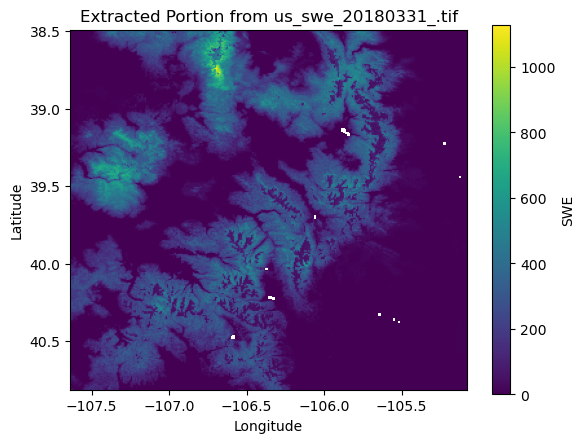

In [5]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to the specific TIFF file you want to plot
filepath = 'SNODAS_tiffs/2018/Mar/us_swe_20180331_.tif'  # Update this to your file's path

# Define the bounding box (min_lon, min_lat, max_lon, max_lat)
bbox = (-107.63823414320551, 40.81405426301586, -105.0780355834649, 38.490518618376115)

# Open the GeoTIFF file
with rasterio.open(filepath) as src:
    # Get the transformation matrix
    transform = src.transform

    # Convert latitude and longitude coordinates to pixel coordinates
    min_lon, min_lat, max_lon, max_lat = bbox
    min_col, min_row = ~transform * (min_lon, min_lat)  # Apply the inverse transformation
    max_col, max_row = ~transform * (max_lon, max_lat)

    # Calculate the width and height of the portion in pixels
    width_px = max_col - min_col
    height_px = max_row - min_row

    # Check if the portion is valid (non-zero width and height)
    if width_px > 0 and height_px > 0:
        # Read the SWE data values for the specified portion
        portion = src.read(1, window=rasterio.windows.Window(min_col, min_row, width_px, height_px))

        # Apply mask to filter out invalid values (-9999)
        masked_portion = np.ma.masked_equal(portion, -9999)

        # Plot the extracted portion
        plt.imshow(masked_portion, cmap='viridis', extent=[min_lon, max_lon, min_lat, max_lat])
        plt.colorbar(label='SWE')  # Add colorbar with label 'SWE'
        plt.title(f'Extracted Portion from {os.path.basename(filepath)}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
    else:
        print('Invalid portion: Width or height is zero.')


CRS: EPSG:4326


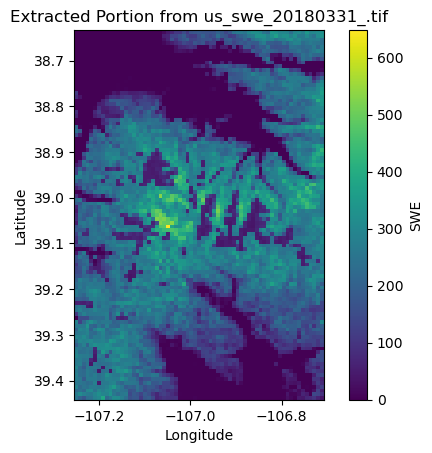

In [27]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to the specific TIFF file you want to plot
filepath = 'SNODAS_tiffs/2018/Mar/us_swe_20180331_.tif'  # Update this to your file's path

# Define the bounding box (min_lon, min_lat, max_lon, max_lat)
bbox = (-107.253386, 39.441667, -106.707933, 38.633333)

# Open the GeoTIFF file
with rasterio.open(filepath) as src:
    # Print the CRS (Coordinate Reference System)
    print("CRS:", src.crs)

    # Get the transformation matrix
    transform = src.transform

    # Convert latitude and longitude coordinates to pixel coordinates
    min_lon, min_lat, max_lon, max_lat = bbox
    min_col, min_row = ~transform * (min_lon, min_lat)  # Apply the inverse transformation
    max_col, max_row = ~transform * (max_lon, max_lat)

    # Calculate the width and height of the portion in pixels
    width_px = max_col - min_col
    height_px = max_row - min_row

    # Check if the portion is valid (non-zero width and height)
    if width_px > 0 and height_px > 0:
        # Read the SWE data values for the specified portion
        portion = src.read(1, window=rasterio.windows.Window(min_col, min_row, width_px, height_px))

        # Apply mask to filter out invalid values (-9999)
        masked_portion = np.ma.masked_equal(portion, -9999)

        # Plot the extracted portion
        plt.imshow(masked_portion, cmap='viridis', extent=[min_lon, max_lon, min_lat, max_lat])
        plt.colorbar(label='SWE')  # Add colorbar with label 'SWE'
        plt.title(f'Extracted Portion from {os.path.basename(filepath)}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
    else:
        print('Invalid portion: Width or height is zero.')


In [49]:
import os
import rasterio
from rasterio.transform import Affine
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
import numpy as np

# Path to the specific TIFF file you want to reproject and clip
filepath = 'SNODAS_tiffs/2018/Mar/us_swe_20180331_.tif'  # Update this to your file's path

# Define the new bounding box in UTM coordinates (min_x, min_y, max_x, max_y)
bbox_utm = (305139.0, 4330251.0, 347139.0, 4281251.0)

# Define the output file path for the clipped raster
output_filepath = 'clipped_reprojected_raster.tif'

# Open the GeoTIFF file
with rasterio.open(filepath) as src:
    # Get the transformation matrix
    transform = src.transform

    # Calculate the transformation parameters for reprojection
    src_crs = src.crs
    dst_crs = 'EPSG:32613'
    dst_transform, width, height = calculate_default_transform(src_crs, dst_crs, src.width, src.height, *src.bounds)

    # Read the raster data
    raster_data = src.read(1)

    # Reproject the raster data to the new CRS and bounding box
    reprojected_data = np.zeros((height, width), dtype=raster_data.dtype)
    reproject(
        source=raster_data,
        destination=reprojected_data,
        src_transform=transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear
    )

    # Get the new bounding box in the source CRS
    min_col, min_row = ~dst_transform * (bbox_utm[0], bbox_utm[1])
    max_col, max_row = ~dst_transform * (bbox_utm[2], bbox_utm[3])

    # Convert row and column indices to integers
    min_row = int(min_row)
    max_row = int(max_row)
    min_col = int(min_col)
    max_col = int(max_col)

    # Calculate the width and height of the portion in pixels
    width_px = max_col - min_col
    height_px = max_row - min_row

    # Check if the portion is valid (non-zero width and height)
    if width_px > 0 and height_px > 0:
        # Extract the portion of the reprojected raster
        clipped_reprojected_data = reprojected_data[min_row:max_row, min_col:max_col]

        # Update the transformation matrix for the clipped portion
        clipped_transform = Affine(dst_transform.a, dst_transform.b, dst_transform.c + min_col * dst_transform.a,
                                    dst_transform.d, dst_transform.e, dst_transform.f + min_row * dst_transform.e)

        # Update the width and height
        clipped_width = clipped_reprojected_data.shape[1]
        clipped_height = clipped_reprojected_data.shape[0]

        # Write the clipped reprojected raster to a new GeoTIFF file
        with rasterio.open(
                output_filepath,
                'w',
                driver='GTiff',
                height=clipped_height,
                width=clipped_width,
                count=1,
                dtype=clipped_reprojected_data.dtype,
                crs=dst_crs,
                transform=clipped_transform,
        ) as dst:
            dst.write(clipped_reprojected_data, 1)

    else:
        print('Invalid portion: Width or height is zero.')


In [52]:
import rasterio

# Open the ASO raster file
with rasterio.open('clipped_snodas_raster.tif') as src:
    # Get the bounding box
    bbox = src.bounds
    print("Bounding box (min_lon, min_lat, max_lon, max_lat):", bbox)


Bounding box (min_lon, min_lat, max_lon, max_lat): BoundingBox(left=-124.73374999999866, bottom=52.449583333332285, right=-124.35041666666535, top=52.87458333333227)


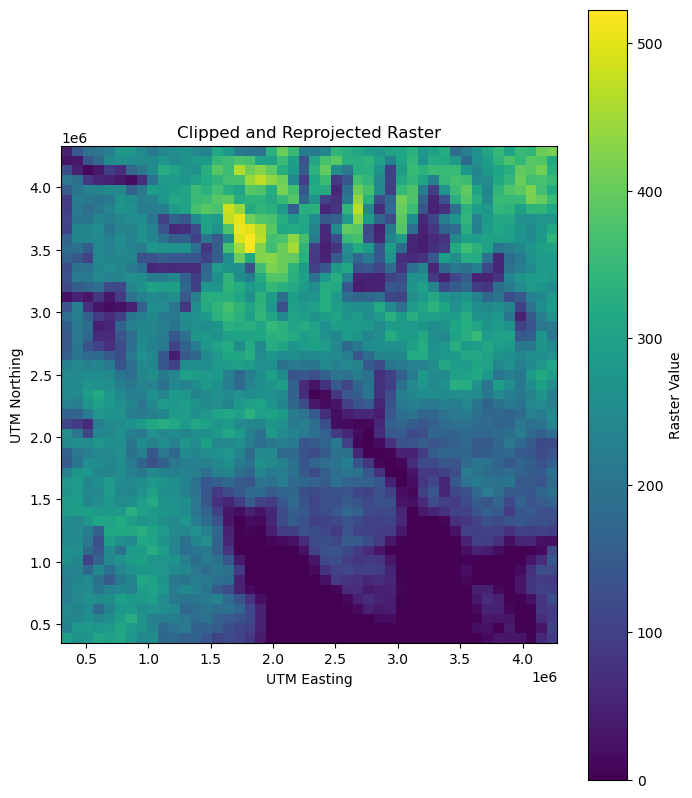

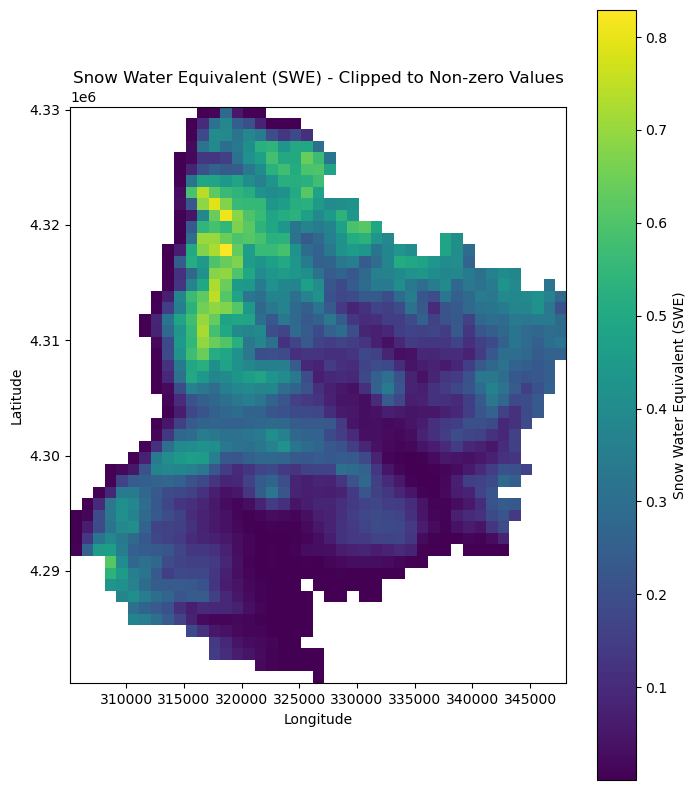

In [59]:
import os
import rasterio
from rasterio.warp import reproject, calculate_default_transform
import numpy as np
import matplotlib.pyplot as plt

# Path to the first raster (in UTM)
utm_raster_path = 'ASO_SWE_Data/ASO_50M_SWE_USCOGE_20180331_clipped.tif'  # Update this with the path to your UTM raster

# Path to the second raster
second_raster_path = 'SNODAS_tiffs/2018/Mar/us_swe_20180331_.tif'  # Update this with the path to your second raster

figsize=(8,10)

# Open the first raster to get CRS and transform information
with rasterio.open(utm_raster_path) as utm_src:
    utm_crs = utm_src.crs
    utm_transform = utm_src.transform

    # Get the dimensions of the first raster
    utm_rows, utm_cols = utm_src.shape

    # Define the extent of the first raster
    utm_extent = rasterio.transform.array_bounds(utm_rows, utm_cols, utm_transform)

    # Open the second raster
    with rasterio.open(second_raster_path) as src:
        # Get the dimensions of the second raster
        rows, cols = src.shape

        # Create an empty array to store the reprojected data
        reprojected_data = np.empty((rows, cols), dtype=src.dtypes[0])

        # Reproject the second raster to the CRS and transform of the first raster (UTM)
        reproject(
            source=rasterio.band(src, 1),
            destination=reprojected_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=utm_transform,
            dst_crs=utm_crs,
            resampling=rasterio.enums.Resampling.bilinear
        )

        # Calculate the window for the area of interest in the reprojected raster
        window = rasterio.windows.from_bounds(*utm_extent, utm_transform)

        # Convert window attributes to integers
        row_off, col_off, height, width = map(int, (window.row_off, window.col_off, window.height, window.width))

        # Read the clipped portion of the reprojected raster
        clipped_data = reprojected_data[row_off:row_off + height, col_off:col_off + width]

        # Plot the clipped portion of the reprojected raster
        plt.figure(figsize=figsize)
        plt.imshow(clipped_data, cmap='viridis', extent=utm_extent)
        plt.colorbar(label='Raster Value')
        plt.title('Clipped and Reprojected Raster')
        plt.xlabel('UTM Easting')
        plt.ylabel('UTM Northing')
        plt.show()

    # Plot Raster 1
    with rasterio.open(utm_raster_path) as src:
        # Read the raster data
        raster_data = src.read(1)

        # Replace -9999 values with 0
        raster_data = np.where(raster_data == -9999, 0, raster_data)

        # Get the metadata for plotting
        transform = src.transform

        # Mask out zero values
        masked_data = np.ma.masked_where(raster_data == 0, raster_data)

        # Get the bounding box of the non-zero region
        ymin, xmin = np.nonzero(masked_data)[0].min(), np.nonzero(masked_data)[1].min()
        ymax, xmax = np.nonzero(masked_data)[0].max(), np.nonzero(masked_data)[1].max()

        # Plot the clipped raster data
        plt.figure(figsize=figsize)
        plt.imshow(masked_data[ymin:ymax + 1, xmin:xmax + 1],
                   cmap='viridis',
                   extent=[utm_extent[0] + xmin * transform[0],
                           utm_extent[0] + (xmax + 1) * transform[0],
                           utm_extent[3] + (ymax + 1) * transform[4],
                           utm_extent[3] + ymin * transform[4]])
        plt.colorbar(label='Snow Water Equivalent (SWE)')
        plt.title('Snow Water Equivalent (SWE) - Clipped to Non-zero Values')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

# Define the output filepath for the ASO raster
output_filepath = 'clipped_aso_raster.tif'

# Write the ASO raster to a new GeoTIFF file
with rasterio.open(
        output_filepath,
        'w',
        driver='GTiff',
        height=clipped_data.shape[0],
        width=clipped_data.shape[1],
        count=1,
        dtype=clipped_data.dtype,
        crs=utm_crs,
        transform=utm_transform,
) as dst:
    dst.write(clipped_data, 1)


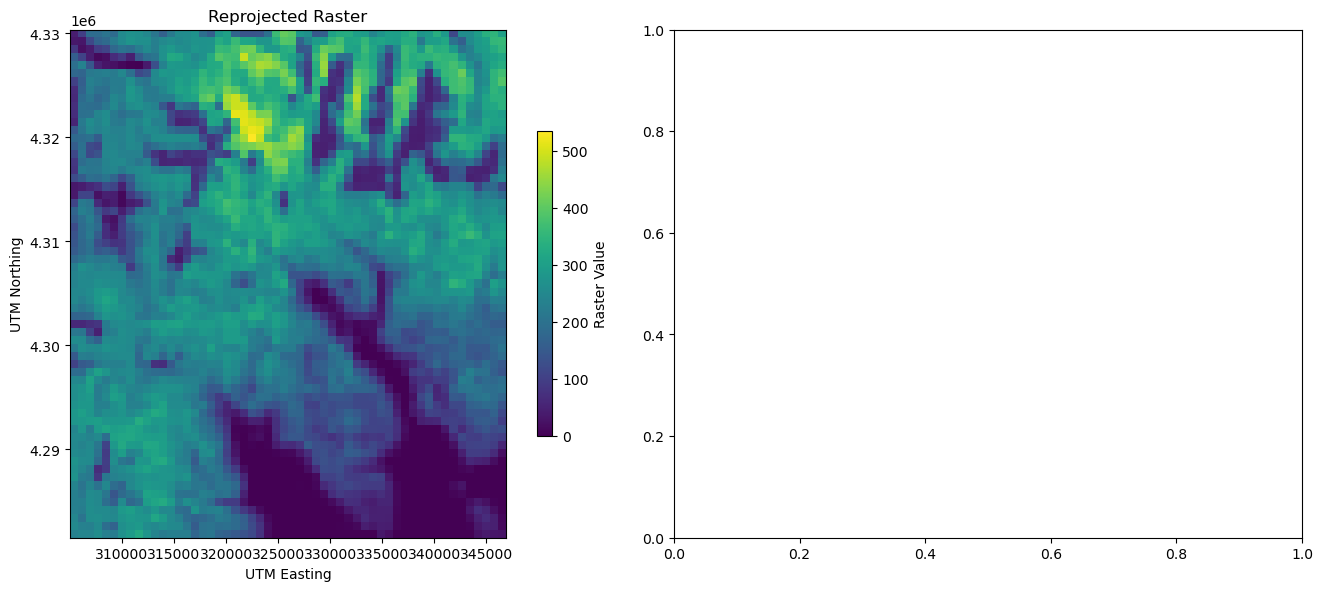

In [4]:
import os
import rasterio
import matplotlib.pyplot as plt

# Path to the reprojected raster file
reprojected_filepath = 'us_swe_20180331_clipped_reprojected_raster.tif'

# Open the reprojected raster
with rasterio.open(reprojected_filepath) as src_reprojected:
    # Read the reprojected raster data
    reprojected_data = src_reprojected.read(1)
    transform_reprojected = src_reprojected.transform
    extent_reprojected = [transform_reprojected[2], transform_reprojected[2] + transform_reprojected[0] * src_reprojected.width,
                          transform_reprojected[5] + transform_reprojected[4] * src_reprojected.height, transform_reprojected[5]]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot reprojected raster
axs[0].imshow(reprojected_data, cmap='viridis', extent=extent_reprojected)
axs[0].set_title('Reprojected Raster')
axs[0].set_xlabel('UTM Easting')
axs[0].set_ylabel('UTM Northing')
axs[0].set_aspect('auto')


# Add colorbars
cbar1 = fig.colorbar(axs[0].imshow(reprojected_data, cmap='viridis', extent=extent_reprojected), ax=axs[0], shrink=0.6)
cbar1.set_label('Raster Value')

# Adjust layout
plt.tight_layout()
plt.show()


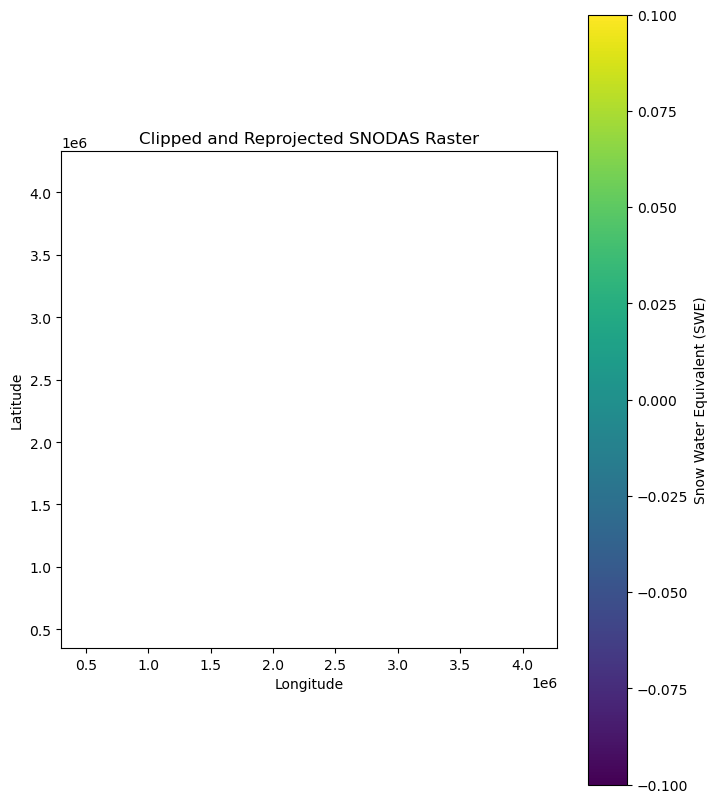

In [16]:
import rasterio
from rasterio.warp import reproject, calculate_default_transform
from rasterio.enums import Resampling
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to the ASO and SNODAS rasters
aso_raster_path = 'ASO_SWE_Data/ASO_50M_SWE_USCOGE_20180331_clipped.tif'
snodas_raster_path = 'SNODAS_tiffs/2018/Mar/us_swe_20180331_.tif'

# Open the ASO raster to get CRS and extent information
with rasterio.open(aso_raster_path) as aso_src:
    aso_crs = aso_src.crs
    aso_extent = aso_src.bounds

    # Reproject the SNODAS raster to the WGS84 CRS
    with rasterio.open(snodas_raster_path) as snodas_src:
        # Calculate the transform and dimensions of the reprojected SNODAS raster
        transform, width, height = calculate_default_transform(
            snodas_src.crs, 'EPSG:4326', snodas_src.width, snodas_src.height, *snodas_src.bounds)
        
        # Define the parameters for reprojecting
        kwargs = {
            'src_crs': snodas_src.crs,
            'src_transform': snodas_src.transform,
            'src_width': snodas_src.width,
            'src_height': snodas_src.height,
            'dst_crs': 'EPSG:4326',
            'dst_transform': transform,
            'dst_width': width,
            'dst_height': height,
            'resampling': Resampling.bilinear
        }

        # Create an empty array to store the reprojected SNODAS data
        reprojected_snodas_data = np.empty((height, width), dtype=snodas_src.dtypes[0])

        # Reproject the SNODAS data
        reproject(
            source=rasterio.band(snodas_src, 1),
            destination=reprojected_snodas_data,
            **kwargs
        )

        # Calculate the window for the area of interest in the reprojected SNODAS raster
        window = rasterio.windows.from_bounds(*aso_extent, aso_src.transform)

        # Clip the window to fit within the bounds of the reprojected SNODAS raster
        window = window.intersection(Window(0, 0, width, height))

        # Convert window attributes to integers
        row_off, col_off, height, width = map(int, (window.row_off, window.col_off, window.height, window.width))

        # Read the clipped portion of the reprojected SNODAS raster
        snodas_data_clip = reprojected_snodas_data[row_off:row_off + height, col_off:col_off + width]

        # Mask out -9999 values
        snodas_data_clip = np.ma.masked_where(snodas_data_clip == -9999, snodas_data_clip)

        # Plot the clipped SNODAS data
        plt.figure(figsize=(8, 10))
        plt.imshow(snodas_data_clip, cmap='viridis', extent=aso_extent)
        plt.colorbar(label='Snow Water Equivalent (SWE)')
        plt.title('Clipped and Reprojected SNODAS Raster')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()


In [68]:
import rasterio
from rasterio.crs import CRS
from rasterio.warp import transform_bounds

# Define the bounding box in UTM coordinates
bbox_aso = (305139.0, 4279251.0, 351139.0, 4330251.0)

# Define the UTM zone (you may need to change this based on your specific location)
utm_zone = 13

# Define the UTM CRS
utm_crs = CRS.from_epsg(32600 + utm_zone)  # UTM zone 13 has EPSG code 32613

# Define the longitude/latitude CRS
latlon_crs = CRS.from_epsg(4326)  # EPSG code for WGS84

# Convert the bounding box coordinates from UTM to latitude-longitude
lon1, lat1, lon2, lat2 = transform_bounds(utm_crs, latlon_crs, *bbox_aso)

# Print the converted bounding box coordinates
print("Bounding box in latitude-longitude coordinates:")
print(f"({lon1}, {lat1}, {lon2}, {lat2})")


Bounding box in latitude-longitude coordinates:
(-107.25338521063617, 38.640403063724236, -106.71064434874138, 39.108706215860195)


In [8]:
import rasterio
import numpy as np
import pandas as pd

def raster_to_csv(raster_path, output_csv, bbox):
    with rasterio.open(raster_path) as src:
        # Get the transformation matrix
        transform = src.transform
        
        # Convert latitude and longitude coordinates to pixel coordinates
        min_lon, min_lat, max_lon, max_lat = bbox
        min_col, min_row = ~transform * (min_lon, min_lat)  # Apply the inverse transformation
        max_col, max_row = ~transform * (max_lon, max_lat)
        
        # Round pixel indices to nearest integer
        min_row, max_row, min_col, max_col = int(round(min_row)), int(round(max_row)), int(round(min_col)), int(round(max_col))

        # Ensure min_row and max_row are in the correct order
        min_row, max_row = min(min_row, max_row), max(min_row, max_row)
        min_col, max_col = min(min_col, max_col), max(min_col, max_col)
        
        # Read the raster data for the portion within the bounding box
        portion = src.read(1, window=((min_row, max_row), (min_col, max_col)))
        
        # Get the latitude and longitude values for each pixel within the bounding box
        rows, cols = np.indices(portion.shape)
        latitudes, longitudes = src.xy(min_row + rows, min_col + cols)

        # Apply mask to filter out NoData values (-9999)
        portion = np.where(portion == -9999, np.nan, portion)
        
        # Flatten the arrays
        latitudes_flat = np.array(latitudes).flatten()
        longitudes_flat = np.array(longitudes).flatten()
        portion_flat = portion.flatten()

        # Create DataFrame with Latitude, Longitude, and Raster Value columns
        data = {'Latitude': latitudes_flat,
                'Longitude': longitudes_flat,
                'Raster_Value': portion_flat}
        df = pd.DataFrame(data)
        
        # Save DataFrame to CSV
        df.to_csv(output_csv, index=False)

# Provide the bounding box for the ASO and SNODAS rasters
bbox_aso = (305139.0, 4279251.0, 351139.0, 4330251.0)
bbox_snodas = (-107.25338521063617, 38.640403063724236, -106.71064434874138, 39.108706215860195)

# Paths to the ASO and SNODAS rasters
aso_raster_path = 'ASO_SWE_Data/ASO_50M_SWE_USCOGE_20180331_clipped.tif'
snodas_raster_path = 'SNODAS_tiffs/2018/Mar/us_swe_20180331_.tif'

# Output CSV file paths
output_csv_aso = 'aso_raster_data.csv'
output_csv_snodas = 'snodas_raster_data.csv'

# Convert raster data to CSV
raster_to_csv(aso_raster_path, output_csv_aso, bbox_aso)
raster_to_csv(snodas_raster_path, output_csv_snodas, bbox_snodas)

print(f"CSV files created: {output_csv_aso}, {output_csv_snodas}")


CSV files created: aso_raster_data.csv, snodas_raster_data.csv


In [6]:
import numpy as np
import rasterio

# Open the raster file
with rasterio.open('ASO_SWE_Data/ASO_50M_SWE_USCOGE_20180331_clipped.tif') as src:
    # Get the pixel resolution
    pixel_resolution = src.res

    # Get the shape of the raster
    raster_shape = src.shape

    # Calculate the mesh gridASO_SWE_Data/ASO_50M_SWE_USCOGE_20180331_clipped.tif
    rows, cols = raster_shape
    x_min, y_max = src.bounds.left, src.bounds.top
    x = np.linspace(x_min + pixel_resolution[0] / 2, x_min + pixel_resolution[0] * (cols - 0.5), cols)
    y = np.linspace(y_max - pixel_resolution[1] / 2, y_max - pixel_resolution[1] * (rows - 0.5), rows)
    xx, yy = np.meshgrid(x, y)

    # Display the mesh grid
    print("Mesh grid shape:", xx.shape, yy.shape)
    print("X coordinates:", xx)
    print("Y coordinates:", yy)


Mesh grid shape: (51, 46) (51, 46)
X coordinates: [[305639. 306639. 307639. ... 348639. 349639. 350639.]
 [305639. 306639. 307639. ... 348639. 349639. 350639.]
 [305639. 306639. 307639. ... 348639. 349639. 350639.]
 ...
 [305639. 306639. 307639. ... 348639. 349639. 350639.]
 [305639. 306639. 307639. ... 348639. 349639. 350639.]
 [305639. 306639. 307639. ... 348639. 349639. 350639.]]
Y coordinates: [[4329751. 4329751. 4329751. ... 4329751. 4329751. 4329751.]
 [4328751. 4328751. 4328751. ... 4328751. 4328751. 4328751.]
 [4327751. 4327751. 4327751. ... 4327751. 4327751. 4327751.]
 ...
 [4281751. 4281751. 4281751. ... 4281751. 4281751. 4281751.]
 [4280751. 4280751. 4280751. ... 4280751. 4280751. 4280751.]
 [4279751. 4279751. 4279751. ... 4279751. 4279751. 4279751.]]


/tmp/ipykernel_679/1714055844.py:33: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp_func = interp2d(x_coords, y_coords, flat_data_values, kind='cubic')
/tmp/ipykernel_679/1714055844.py:36: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new c

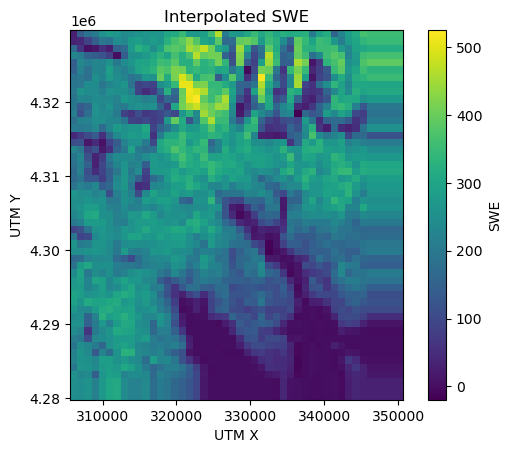

In [5]:
import numpy as np
import rasterio
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import pandas as pd

# Open the raster files
with rasterio.open('ASO_SWE_Data/ASO_50M_SWE_USCOGE_20180331_clipped.tif') as src1, \
     rasterio.open('us_swe_20180331_clipped_reprojected_raster.tif') as src2:
    # Get the pixel resolution
    pixel_resolution = src1.res

    # Get the shape of the raster
    raster_shape = src1.shape

    # Calculate the mesh grid
    rows, cols = raster_shape
    x_min, y_max = src1.bounds.left, src1.bounds.top
    x = np.linspace(x_min + pixel_resolution[0] / 2, x_min + pixel_resolution[0] * (cols - 0.5), cols)
    y = np.linspace(y_max - pixel_resolution[1] / 2, y_max - pixel_resolution[1] * (rows - 0.5), rows)
    xx, yy = np.meshgrid(x, y)
    
    # Get values of second raster
    data_values = src2.read(1)
    flat_data_values = data_values.flatten()

    # Get affine transformation coefficients
    transform = src2.transform
    row, col = np.indices(data_values.shape)
    x_coords, y_coords = transform * (col, row)  # Apply transformation to get coordinates
    
    # Create interpolation function
    interp_func = interp2d(x_coords, y_coords, flat_data_values, kind='cubic')

    # Interpolate second raster onto the meshgrid
    interpolated_data = interp_func(x, y)

    # Plot the interpolated data
    plt.imshow(interpolated_data, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
    plt.colorbar(label='SWE')
    plt.xlabel('UTM X')
    plt.ylabel('UTM Y')
    plt.title('Interpolated SWE')
    plt.show()

    # Save UTM coordinates and raster values (SWE) into a CSV file
    #df = pd.DataFrame({'UTM_X': xx.flatten(), 'UTM_Y': yy.flatten(), 'SWE': interpolated_data.flatten()})
    #df.to_csv('cubic_interpolated_data.csv', index=False)
